In [6]:
import pandas as pd
import numpy as np
import ast
import sys
import warnings 
import matplotlib.pyplot as plt
warnings.simplefilter("ignore")
from datetime import timedelta, datetime
import plotly.graph_objs as go


In [2]:
# Re-running the code including all the steps from generating the datetime range to creating the DataFrame

# Number of rows
n_rows = 2000

# Generate a datetime range
date_range = pd.date_range(start='2023-01-01', periods=n_rows, freq='T')
date_range = date_range + pd.to_timedelta(np.random.randint(0, 60, size=n_rows), unit='s')

# Convert to a list to allow shuffling
date_list = date_range.to_list()
np.random.shuffle(date_list)

# Generate random States
states = np.random.choice(['A', 'B', 'C'], size=n_rows)

# Generate NormalizedPnlRate
normalized_pnl_rate = np.random.uniform(-100, 100, size=n_rows)

# Create the DataFrame
data = {
    'Time': date_list,
    'State': states,
    'NormalizedPnlRate': normalized_pnl_rate
}

df = pd.DataFrame(data)

# Sort by Time to have ascending order
df.sort_values(by='Time', inplace=True)

# Display the first few rows
df.head()

,Time,State,NormalizedPnlRate
1389,2023-01-01 00:00:40,B,87.740940
986,2023-01-01 00:01:42,B,26.846443
1433,2023-01-01 00:02:26,B,-32.869363
365,2023-01-01 00:03:49,A,59.958124
1547,2023-01-01 00:04:08,A,64.533965


In [13]:
df = df.set_index('Time')
df

,State,NormalizedPnlRate
Time,,
2023-01-01 00:00:40,B,87.740940
2023-01-01 00:01:42,B,26.846443
2023-01-01 00:02:26,B,-32.869363
2023-01-01 00:03:49,A,59.958124
2023-01-01 00:04:08,A,64.533965
...,...,...
2023-01-02 09:15:01,C,58.853293
2023-01-02 09:16:32,A,67.625507
2023-01-02 09:17:51,B,-72.450267


Normalized PnL for State: B
count    689.000000
mean       2.573937
std       58.299905
min      -99.823235
25%      -49.106338
50%        5.738187
75%       53.417382
max       99.878378
Name: NormalizedPnlRate, dtype: float64
P-value: 2.5085787058189667e-14
Sample does not look Gaussian (reject H0)


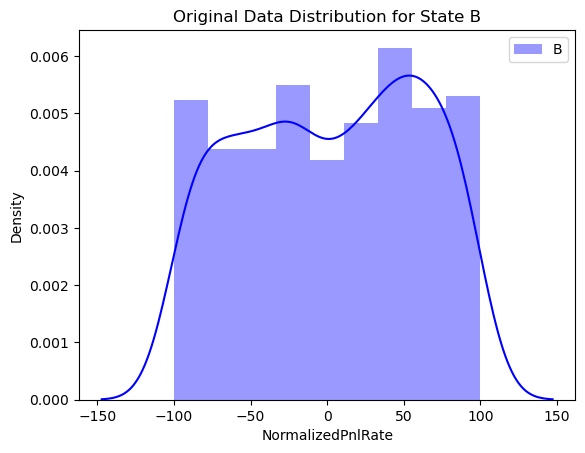

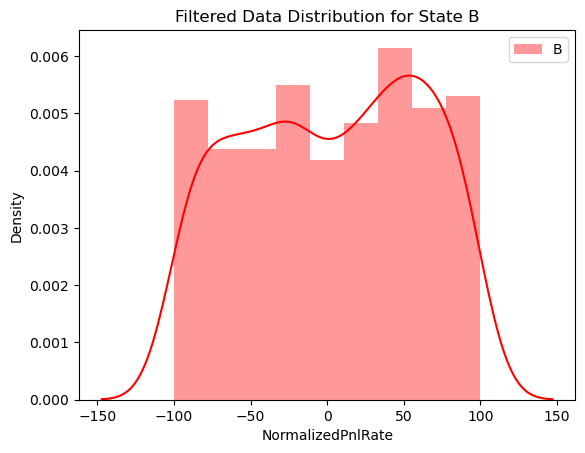

Normalized PnL for State: A
count    683.000000
mean      -0.192647
std       56.586947
min      -99.041114
25%      -49.217147
50%       -0.296393
75%       49.171862
max       99.339397
Name: NormalizedPnlRate, dtype: float64
P-value: 2.8506694617694284e-13
Sample does not look Gaussian (reject H0)


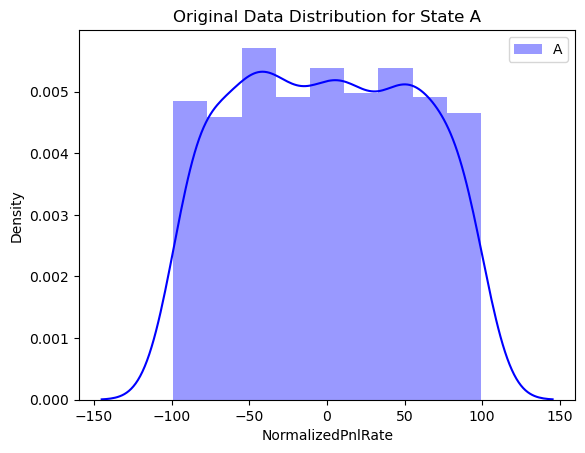

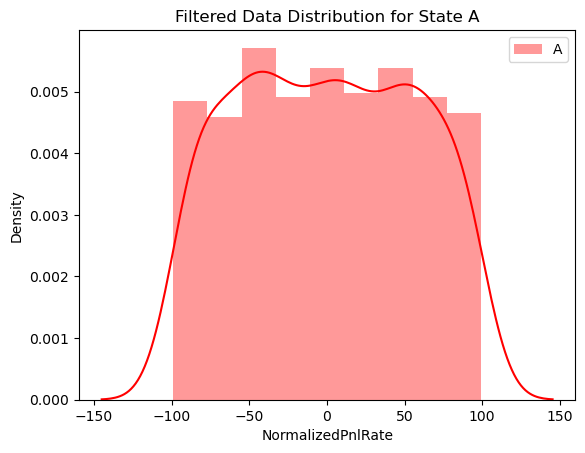

Normalized PnL for State: C
count    628.000000
mean       0.979971
std       56.488700
min      -99.598039
25%      -47.277327
50%        2.743769
75%       46.555044
max       99.436644
Name: NormalizedPnlRate, dtype: float64
P-value: 1.6026771923471905e-11
Sample does not look Gaussian (reject H0)


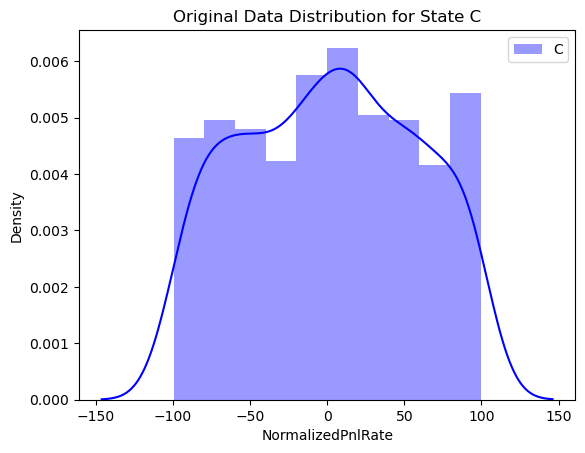

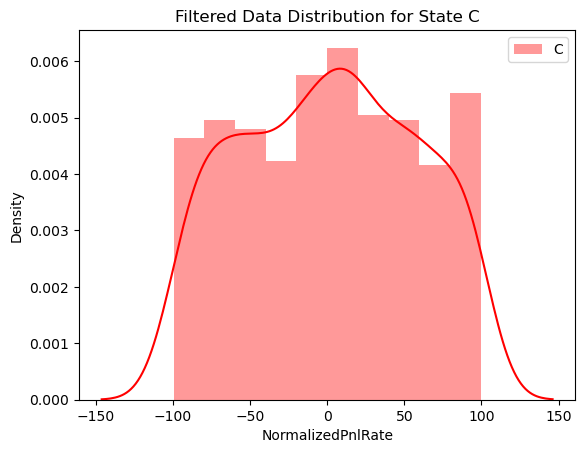

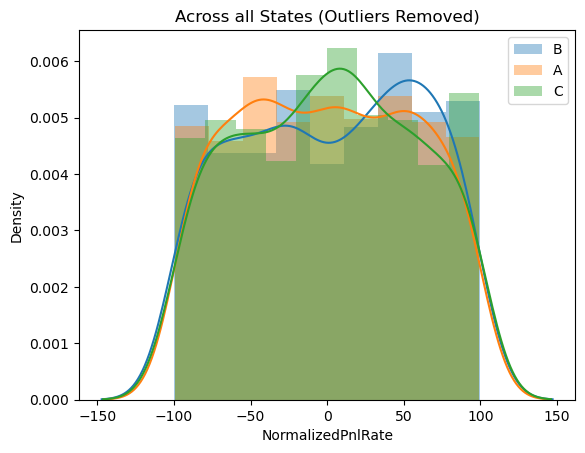

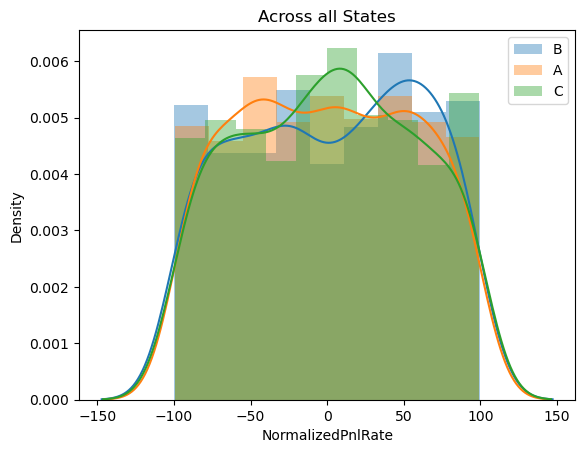

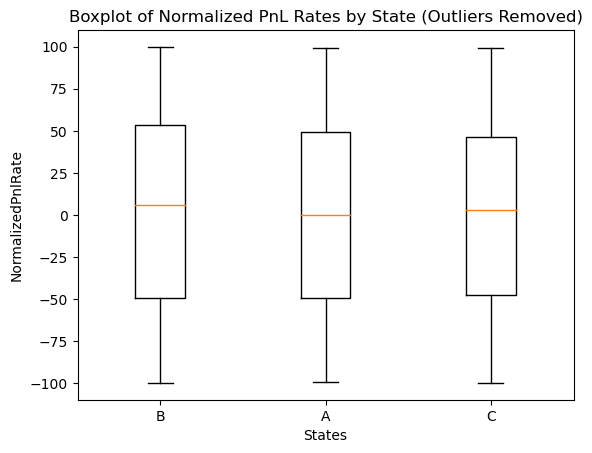

In [14]:
import scipy
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro

def analyze_normalized_pnl(df, column_name='NormalizedPnlRate'):
    states_list = df['State'].unique()
    removed_outliers = {}

    for state in states_list:
        df_state = df[df['State'] == state][column_name]
        Q1 = df_state.quantile(0.25)
        Q3 = df_state.quantile(0.75)
        IQR = Q3 - Q1
        df_filtered = df_state[~((df_state < (Q1 - 1.5 * IQR)) | (df_state > (Q3 + 1.5 * IQR)))]
        removed_outliers[state] = df_filtered

        print('==================================================================')
        print('Normalized PnL for State:', state)
        print(df_state.describe())
        print('==================================================================')

        stat, p = shapiro(df_filtered)
        alpha = 0.05
        if p > alpha:
            print('P-value:', p)
            print('Sample looks Gaussian (fail to reject H0)')
        else:
            print('P-value:', p)
            print('Sample does not look Gaussian (reject H0)')

        sns.distplot(df_state, color="blue", label=state)
        plt.title(f'Original Data Distribution for State {state}')
        plt.legend()
        plt.show()

        sns.distplot(df_filtered, color="red", label=state)
        plt.title(f'Filtered Data Distribution for State {state}')
        plt.legend()
        plt.show()

    plt.title('Across all States (Outliers Removed)')
    for state in states_list:
        sns.distplot(removed_outliers[state], label=state)
    plt.legend()
    plt.show()

    plt.title('Across all States')
    for state in states_list:
        sns.distplot(df[df['State'] == state][column_name], label=state)
    plt.legend()
    plt.show()

    positions = range(1, len(states_list) + 1)
    plt.boxplot([removed_outliers[state] for state in states_list], positions=positions)
    plt.xticks(positions, states_list)
    plt.xlabel('States')
    plt.ylabel(column_name)
    plt.title('Boxplot of Normalized PnL Rates by State (Outliers Removed)')
    plt.show()

# Example usage with the generated DataFrame
analyze_normalized_pnl(df)


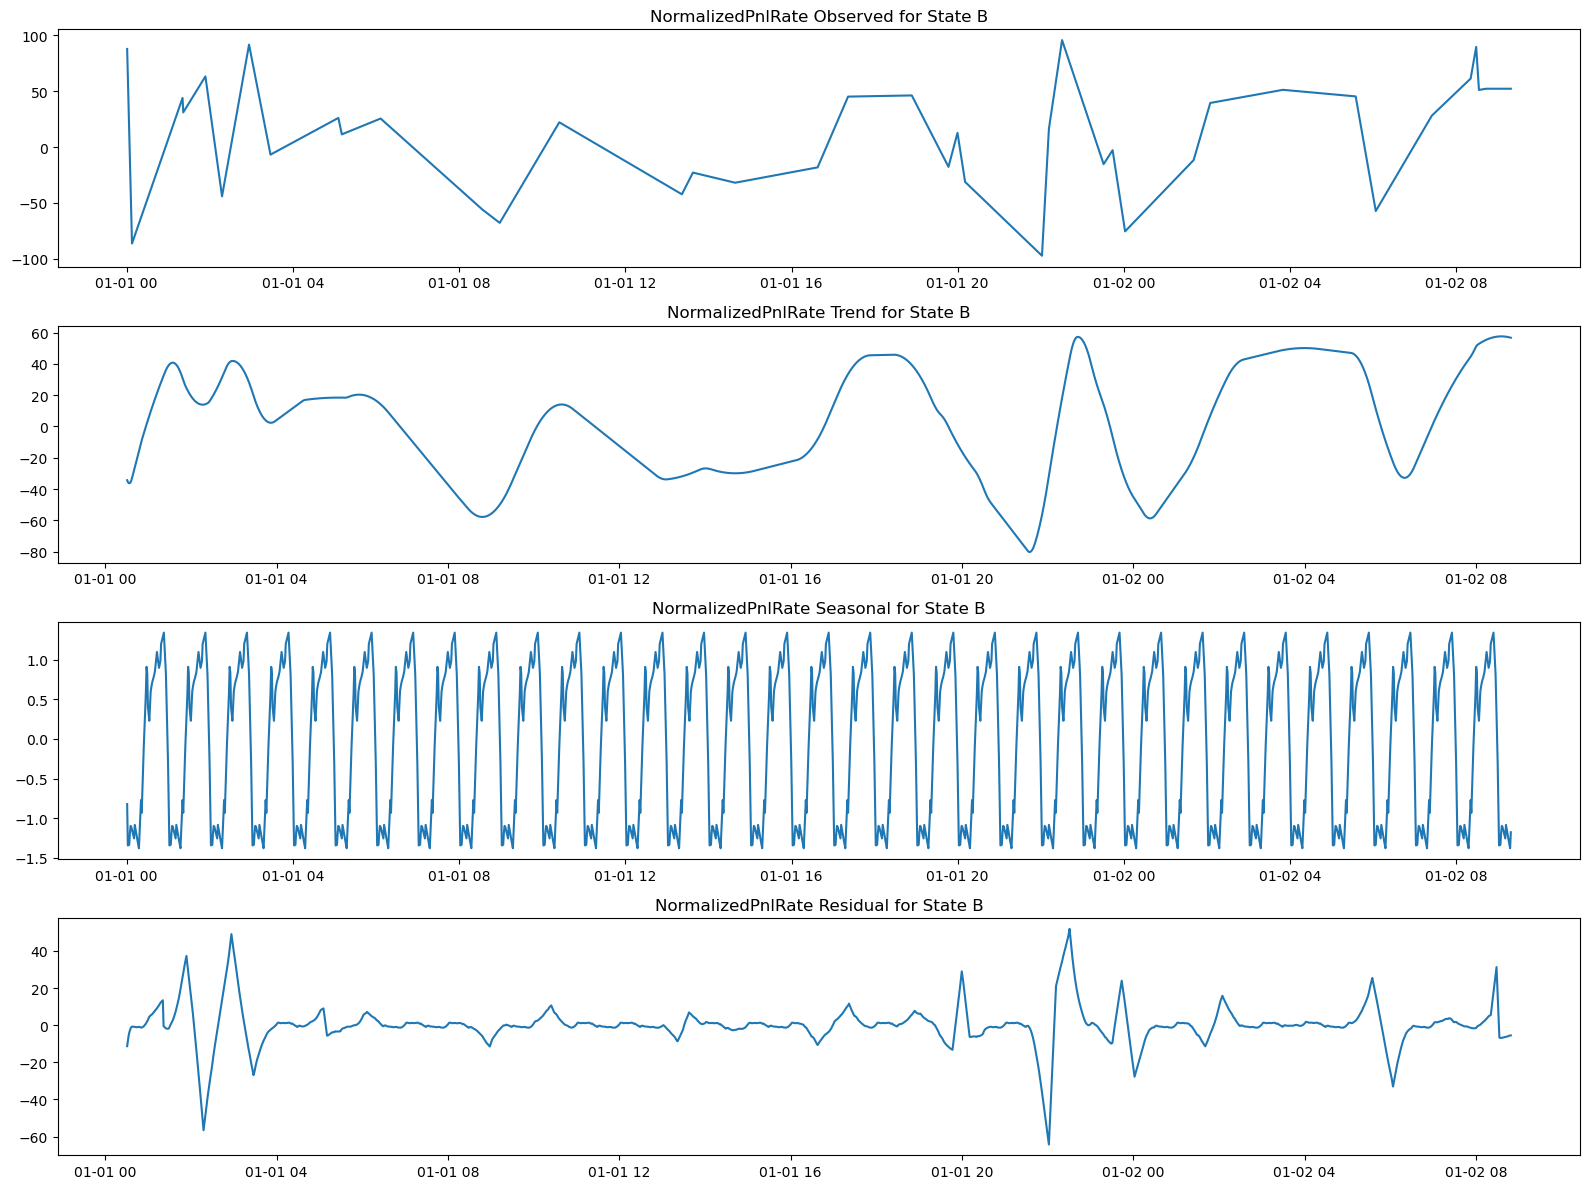

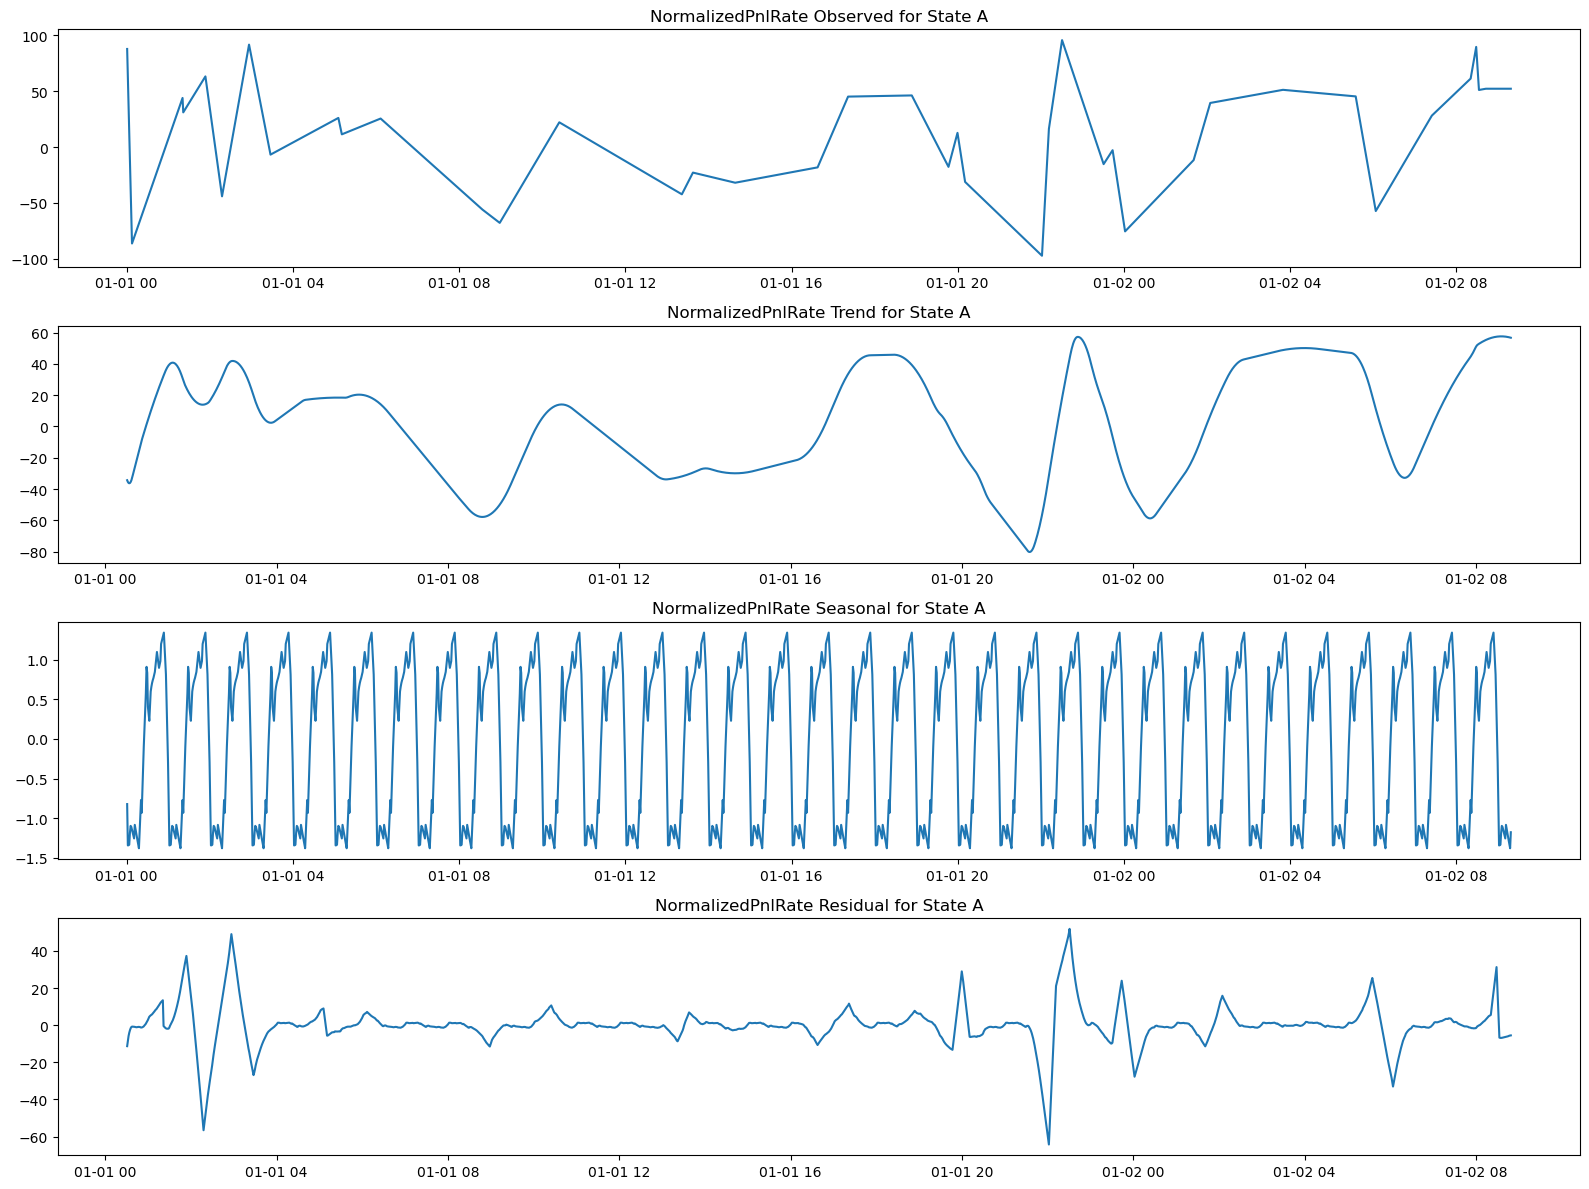

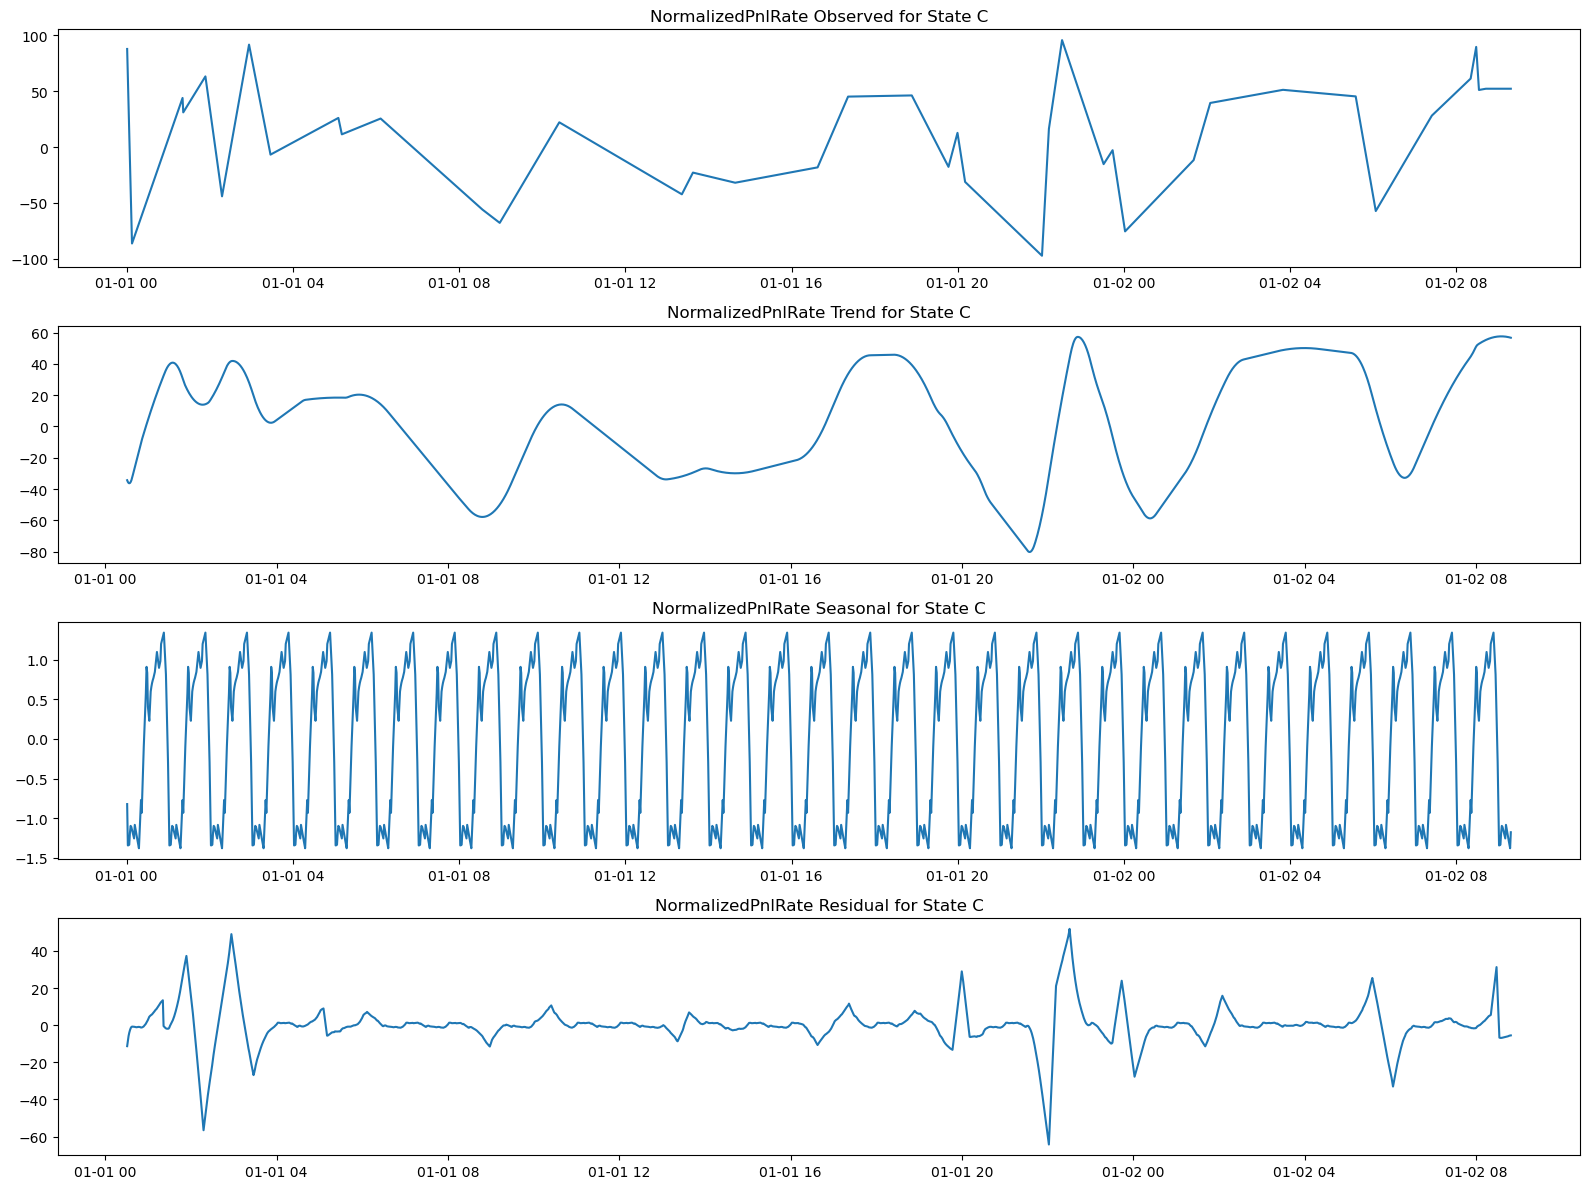

In [23]:
import statsmodels.api as sm
from matplotlib import rcParams
import matplotlib.pyplot as plt

def seasonal_decompose_pnl(df, column_name='NormalizedPnlRate', freq='T', period=60):
    states_list = df['State'].unique()

    for state in states_list:
        df_state = df.asfreq(freq).interpolate(method='time')  # Ensure consistent frequency and interpolate missing values

        decomposition = sm.tsa.seasonal_decompose(df_state[column_name], model='additive', period=period)

        rcParams["figure.figsize"] = 16, 12

        plt.figure()
        plt.subplot(411)
        plt.plot(decomposition.observed)
        plt.title(f'{column_name} Observed for State {state}')

        plt.subplot(412)
        plt.plot(decomposition.trend)
        plt.title(f'{column_name} Trend for State {state}')

        plt.subplot(413)
        plt.plot(decomposition.seasonal)
        plt.title(f'{column_name} Seasonal for State {state}')

        plt.subplot(414)
        plt.plot(decomposition.resid)
        plt.title(f'{column_name} Residual for State {state}')

        plt.tight_layout()
        plt.show()

# Example usage with the generated DataFrame
seasonal_decompose_pnl(df)
